In [203]:
import os
import time
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
import galsim

from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '4'})
rcParams.update({'xtick.major.width': '1.'})
rcParams.update({'xtick.minor.pad': '5.0'})
rcParams.update({'xtick.minor.size': '4'})
rcParams.update({'xtick.minor.width': '0.8'})
rcParams.update({'ytick.major.pad': '5.0'})
rcParams.update({'ytick.major.size': '4'})
rcParams.update({'ytick.major.width': '1.'})
rcParams.update({'ytick.minor.pad': '5.0'})
rcParams.update({'ytick.minor.size': '4'})
rcParams.update({'ytick.minor.width': '0.8'})
rcParams.update({'font.size': 14})
rcParams.update({'legend.title_fontsize': 16})
rcParams.update({'axes.titlesize': 16})

from utils import *

In [168]:
# Parameters
pixel_scale = 2.5           # arcsec/pixel
psf_beta = 3                # beta
fwhm = 2.2 * 2.5            # arcsec
gamma = fwhm / 2. / np.sqrt(2**(1./psf_beta)-1)  #in arcsec
gamma_pix = gamma / pixel_scale                  #in pix

n = 2.35
theta_t = 10                # in arcsec
a = 1 / (theta_t)**(-n)     # normalization

print(" Core Width: %.2f''/ %.2f pix, Power Index: %.2f"%(gamma, gamma_pix, psf_beta))

image_size = 64                 # size of image in pixels

random_seed = 24783923
rng = galsim.BaseDeviate(random_seed)

 Core Width: 5.39''/ 2.16 pix, Power Index: 3.00


In [178]:
def trunc_power2d(x, y, n, theta0, I_theta0, cen): 
    r = np.sqrt((x-cen[0])**2 + (y-cen[1])**2) + 1e-6
    a = I_theta0 / (theta0)**(-n)
    z = a * np.power(r, -n) 
    z[r<theta0] = I_theta0
    return z

### Build Galsim Power Law PSF

Build galsim power law PSF from astropy image. We use a truncated power law where the inner part within theta_tr is constant. We set the PSF with high resolution and ensure the PSF extends with contrast > 10^4 (peak to edge) so the PSF is not truncated.

PSF size:  1007


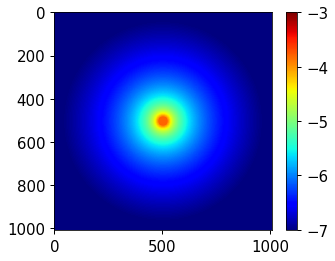

In [197]:
contrast = 1e4
psf_size = 2 * np.int((contrast * a) ** (1./n)) + 1
print("PSF size: ", psf_size)
psf_pixel_scale = 0.5           #in arcsec

cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
rr_psf = np.sqrt((xx_psf-cen_psf[0])**2+(yy_psf-cen_psf[1])**2)

psf_model = trunc_power2d(xx_psf, yy_psf, n, cen=cen_psf, theta0=theta_t/psf_pixel_scale, I_theta0=1) 
            
from astropy.convolution import Kernel,convolve_fft
psf_kernel = Kernel(psf_model.copy())
psf_kernel.normalize(mode="integral")
im = plt.imshow(np.log10(psf_kernel.array), vmin=-7, vmax=-3, cmap="jet")
colorbar(im)

Maximum R: 503 (pix)


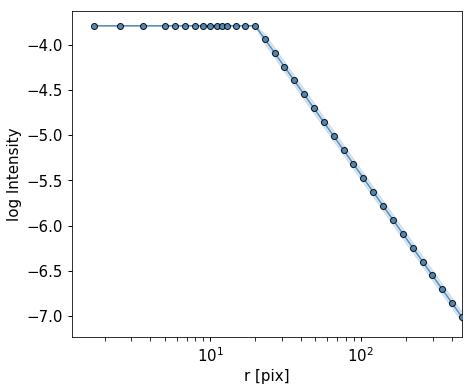

In [194]:
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(psf_kernel.array, xunit="pix", yunit="intensity")
plt.xscale("log")

In [201]:
image_psf = galsim.ImageF(psf_kernel.array)
gsparams = galsim.GSParams(folding_threshold=1.e-5)
psf_pow = galsim.InterpolatedImage(image_psf, scale=psf_pixel_scale, gsparams=gsparams)

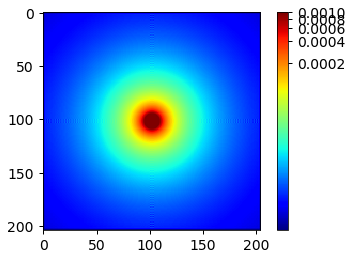

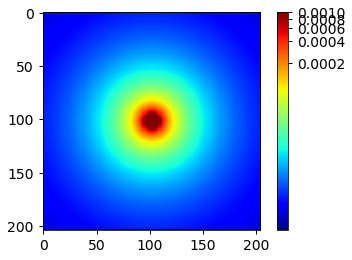

In [204]:
im1 = psf_pow.drawImage(scale=2.5, method="fft").array
im2 = psf_pow.drawImage(scale=2.5, method="no_pixel").array
plt.figure()
plt.imshow(im1,  vmin=1e-7, vmax=1e-3, norm=norm1, cmap="jet")
plt.colorbar()
plt.figure()
plt.imshow(im2,  vmin=1e-7, vmax=1e-3, norm=norm1, cmap="jet")
plt.colorbar()

### Combined with Galsim Moffat PSF

 Core Width: 5.39''/ 2.16 pix, Power Index: 3.00


Text(0.5, 1.0, 'Galsim 2D Moffat')

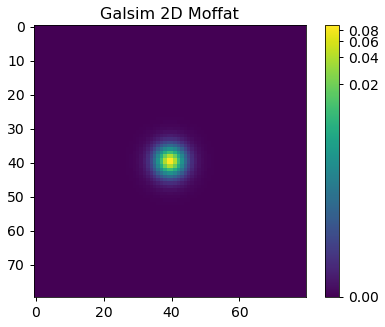

In [205]:
# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-5)
psf_mof = galsim.Moffat(beta=psf_beta, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

# Draw the image
img_mof = psf_mof.drawImage(scale=pixel_scale, method="fft").array

plt.figure(figsize=(7,5))
im = plt.imshow(img_mof, vmin=0, vmax=img_gs.max(), norm=norm1)
plt.colorbar(im)
plt.title("Galsim 2D Moffat")

In [206]:
star = 0.9 * psf_mof + 0.1 * psf_pow 

Text(0.5, 1.0, 'Galsim 2D Moffat')

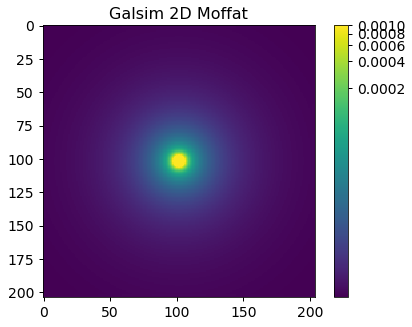

In [207]:
img_gs = star.drawImage(scale=2.5, method="no_pixel").array
plt.figure(figsize=(7,5))
im = plt.imshow(img_gs, vmin=1e-7, vmax=1e-3, norm=norm1)
plt.colorbar(im)
plt.title("Galsim 2D Moffat")

Maximum R: 102 (pix)


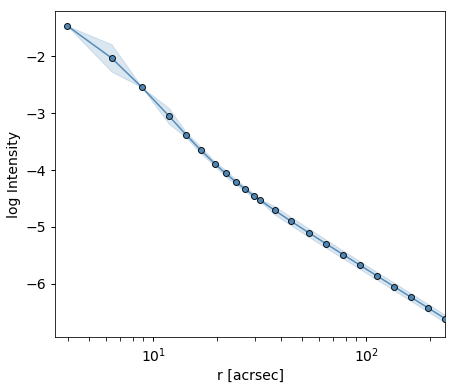

In [208]:
plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_gs, pix_scale=2.5, xunit="arcsec", yunit="intensity")
plt.xscale("log")

### Compare with Dragonfly stacked PSF

Maximum R: 49 (pix)
Maximum R: 102 (pix)


(-7, -1)

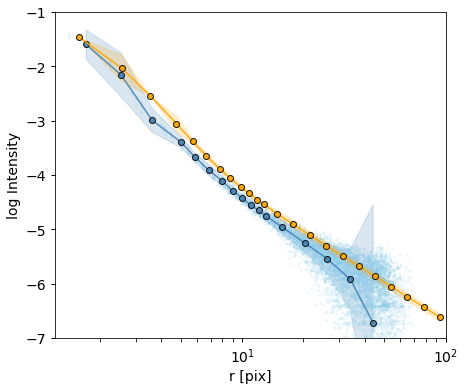

In [210]:
PSF_JX = fits.open("./med_psf_JX.fits")[0].data / 1e5
cen = (PSF_JX.shape[0]-1)/2., (PSF_JX.shape[1]-1)/2.
yy, xx = np.indices((PSF_JX.shape))
rr = np.sqrt((xx - cen[0])**2 + (yy - cen[1])**2)

plt.figure(figsize=(7,6))
r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(PSF_JX, pix_scale=2.5, xunit="pix")
plt.scatter(rr[PSF_JX>0], np.log10(PSF_JX[PSF_JX>0]), color="skyblue", s=3, alpha=0.1)
plt.xscale("log")

r_rbin, z_rbin, logzerr_rbin, use_range = cal_profile_1d(img_gs, pix_scale=2.5, color="orange",
                                                         xunit="pix", yunit="intensity")

plt.xlim(1.2,100)
plt.ylim(-7,-1)